# Generating Cosmological Initial Conditions

A tutorial for the class "Structure Formation in the Early Universe" (Prof. Andrei Mesinger)

**Author:** Nikolaos (Nikos) Triantafyllou <br>
**email:** nikolaos.triantafyllou@sns.it<br>
**webpage:** https://nikos-triantafyllou.github.io/ <br>

In this tutorial we will learn how to generate **initial conditions** (ICs), i.e., the **density field at high redshifts (z~few hundred)**. We will make our own ICs generator and then we will switch to the code `21cmFAST` and the corresponding tool package `tuesday`.
<br> As Carl Sagan once said: "If you wish to make an apple pie from scratch, you must first invent the Universe.🌌"

---

### Table of Contents <a class="anchor" id="top"></a>

<!-- * [0 Imports](#ICs_DIY) -->
* [PART 1: Generate your own ICs](#ICs_DIY)
  * [1.1 Gaussian Random Fields (GRFs)](#specify_ps)
  * [1.2 Specify a Power Spectrum (PS)](#specify_ps)
  * [1.3 Compute a Realization](make_realization)
    * [1.3.1 Compute realization PS](#realiz_PS)
  * [1.4 Change seeds, amplitude and tilt and see results](#change_seeds)

    
* [PART 2: Introduction to `21cmFAST`](#intro_to_21cmFAST)
    * [2.1 Create ICs and plot slice, velocity field, PDF,  PS](#create_ICs)
    * [2.2 Change the cosmology, and plot the difference wrt fiducial (slice, PDF, PS and ratio, CCC)](#different_cosmo).
    
Appendix

* [A.1 Sanity check that the mean of the field in real space is determined by the DC mode](#Nyquist)
* [A.2 Learn what the Nyquist frequency is](#Nyquist)
* [A.3 Why is the PS realization usually below the theoretical one?](#PS_statistics)
* [A.4 Non-Gaussianities](#NG)


Notes:
- All lengths are expressed in $\rm Mpc$ and all inverse lengths in $\rm Mpc^{-1}$
- If you run plotting functions from `tuesday` the default fontsize for plots is likely to change.

---

## Begin initialization

In [ ]:
# 21cmFAST installation
!sudo apt-get install libfftw3-dev libgsl-dev
%pip install pip --upgrade
%pip install 21cmFAST==4.0.0b0 tuesday-eor

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
  libgsl27 libgslcblas0
Suggested packages:
  libfftw3-doc gsl-ref-psdoc | gsl-doc-pdf | gsl-doc-info | gsl-ref-html
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-double3 libfftw3-long3 libfftw3-quad3
  libfftw3-single3 libgsl-dev libgsl27 libgslcblas0
0 upgraded, 9 newly installed, 0 to remove and 38 not upgraded.
Need to get 7,006 kB of archives.
After this operation, 35.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-double3 amd64 3.3.8-2ubuntu8 [770 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu8 [335 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-quad3 amd64 3.3.8-2ubuntu8 [614 kB]
Get:4 htt

In [ ]:
# Standard initialization for 21cmFAST tutorials
import py21cmfast as p21c
import numpy as np
import matplotlib.pyplot as plt
import imageio
from scipy.integrate import quad
from py21cmfast import plotting
from py21cmfast.wrapper import cfuncs as cf # C function hooks
from astropy import units
import astropy.constants as const
import astropy.cosmology as cosmo
from tempfile import mkdtemp
from pathlib import Path
import cv2
import os
from tqdm import tqdm
import tuesday.core as tools

cache = p21c.OutputCache("./Cache") # Create a temporary directory for the cache

## End initialization

---

# PART 1: Genarate your own Initial Conditions (ICs) <a class="anchor" id="info"></a>



<br>
<br>
<br>

## 1.1 Gaussian Random Fields (GRFs)

What are the ICs? As mentioned before, the **density field at high redshifts (z~few hundred)**. Usually the linearly-extrapolated (at $z=0)$ overdensity field ($\delta$) is used, i.e., $\delta=\rho/ \bar{\rho}-1$, where $\rho$ the density. Based on the current model for cosmology the ICs are a Gaussian Random Field (GRF) $^1$.

A **GRF** is a collection of Random Variables (RVs) that are drawn from Multi-variate Gaussian Distribution defined by some mean (strictly speaking expectation value) $E(x)$ and covariance $C(x,y)$, where $x,y$ positions in space (of any dimensionality).

In cosmology when we use the term GRF, we usually refer to a ***homogeneous and isotropic GRF*** $^2$.
In practice, this means that the commonly assumed conditions is that the mean is constant throughout the field $E(x) = \mu$ and that the covariance only depends on the magnitude of the separation of $x$ and $y$ i.e. $C(x,y) = C(||x-y||)$.
In this case, the GRF is purely described by its **1D Power Spectrum (PS)** (sometimes referred just as the power spectrum, isotropic power spectrum or power spectral density).

So let's define a PS to generate ICs!

<br>
<br>
<br>

## 1.2 Specify PS  <a class="anchor" id="specify_ps"></a>

As mentioned in class, the theoretical power spectrum is $$P(k) = \sigma_k^2 \cdot V^{-1} = \langle|\delta_k|^2\rangle \cdot V^{-1} = A k^n T^2(k) D^2(z, k)\;\;\;\;\;\;\;\;\;\;\;\;(1)$$

where compared with the class notes, we have added the $V^{-1}$ term to follow the convention in ${\tt 21cmFAST}$.

We only need to specify some functional form of $T(k)$ and $D(z,k)$.

Since we usually use the linearly extrapolated overdensity field at $z=0$, if we asssume scale independent growth $D(k,z) = D(z)$, we can omit the growth factor $D$ since it's defined to be unity at $z=0$, i.e., $D(0)=1$. This is only for this class, next class we will see how perturbations evolve through redshift.

In [ ]:
# Assume some (flat) cosmology
OMm          = 0.3         # Total mass density (CDM baryons and massive neutrinos)
OMb          = 0.05        # Baryon density
PS_index     = 0.9665      # tilt of the power spectrum, "n" in Eq. 1
PS_amplitude = 1.12e+07    # "A" in Eq. 1. Same qualitative effect of sigma_8
hlittle      = 0.7

Now let's implement Eqs 4,5 from https://arxiv.org/pdf/astro-ph/9512102 to code the `Transfer_function`, `PS` and `dimensionless_PS` ($\Delta_k$ in the Notes) as a function of `k` using `def`.

In [ ]:
# Use some simple form of T(k)
# Eqs 4,5 from https://arxiv.org/pdf/astro-ph/9512102
Gamma_liddle = OMm* hlittle* np.exp(-OMb - OMb/OMm)
def Transfer_function(k):
    qk = k/(hlittle* Gamma_liddle)
    return np.log(1 + 2.34* qk) /  (2.34*qk)  *    ( 1 + 3.89* qk + (16.1* qk)**2  + (5.46* qk)**3 + (6.71* qk)**4 )**(-1/4.)

def PS(k):
    return PS_amplitude * k**PS_index * Transfer_function(k)**2

def dimensionless_PS(k):
    return pow(k,3)/(2*pow(np.pi,2)) * PS(k)

Now let's plot all of them as a function of `k`. You can define a logarithmic k range by `k_arr = np.logspace(-3,1,100)` and plot with `plt.loglog(k_arr, function(k_arr))`, where `function` is one function from above.

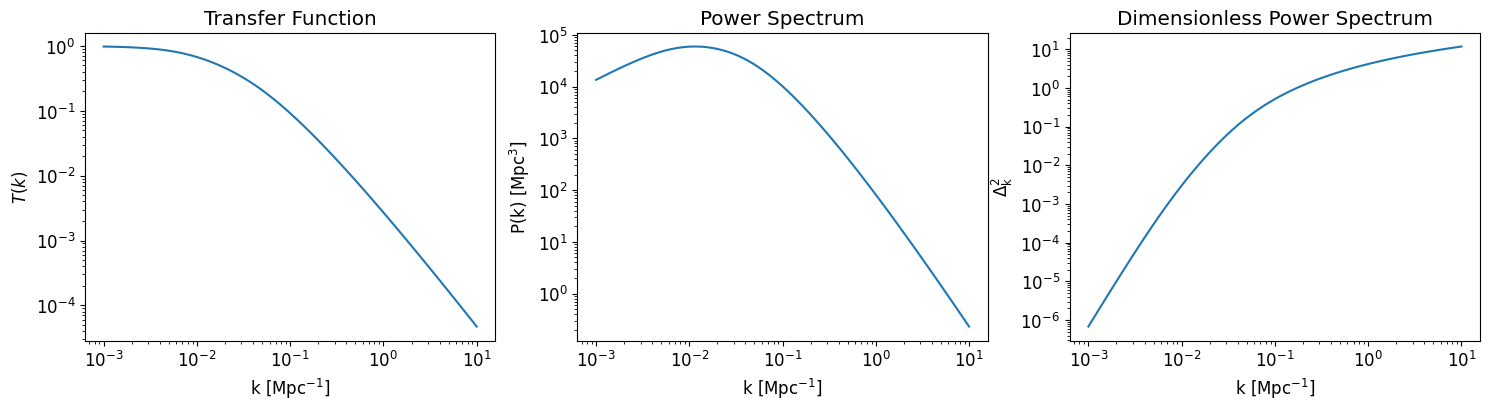

In [ ]:
# Define some k range
fig, ax = plt.subplots(1,3, figsize=(18,4))
k_arr = np.logspace(-3,1,100)
ax[0].loglog(k_arr, Transfer_function(k_arr))
ax[1].loglog(k_arr, PS(k_arr))
ax[2].loglog(k_arr, dimensionless_PS(k_arr))

ax[0].set_xlabel(r'$\rm k~[Mpc^{-1}]$')
ax[0].set_ylabel(r'$T(k)$')
ax[0].set_title('Transfer Function');

ax[1].set_xlabel(r'$\rm k~[Mpc^{-1}]$')
ax[1].set_ylabel(r'$\rm P(k)~[Mpc^{3}]$')
ax[1].set_title('Power Spectrum');

ax[2].set_xlabel(r'$\rm k~[Mpc^{-1}]$')
ax[2].set_ylabel(r'$\rm \Delta_k^2$')
ax[2].set_title('Dimensionless Power Spectrum');

> 📝 **Exercise**  
> Can you change PS_amplitude with sigma8? <br>To integrate a function from 0 to infinity you can use `quad(lambda k: function(k), 0, np.inf)[0]` <br>
> 📝 **Exercise**  
> After completing the previous exercise, use another window function to see how the amplitude changes.


### Expand to see solution ⬇️

---



In [ ]:
SIGMA8=0.82

# Compute normalization--------------------------------------------------------------------------
# We need   A * sigma_m^2(R = 8 h^-1Mpc) = SIGMA_8^2 => A = SIGMA_8^2 / sigma_m^2(R = 8 h^-1Mpc)
R = 8/hlittle
Vw = 4*np.pi/3  * pow(R, 3) # Volume of the spherical top hat (Notes Eq. 106)

def window(k): # (Notes Eq. 106)
        return Vw*3 * (    np.sin(k*R) / pow(k* R , 3)  - np.cos(k * R) / pow(k* R , 2)  )

def integrand(k): # (Notes integrand in Eq. 104)
    return dimensionless_PS(k) / PS_amplitude     *     pow(window(k), 2)     *    1/k * pow(Vw, -2) # Here we divided also by the PS_amplitude to remove the effect of the previous normalization

sigma_m2 =  quad(lambda k: integrand(k), 0, np.inf)[0]
A = SIGMA8**2 / sigma_m2

print("PS_amplitude needed for sigma_8 = {} is {:.2e}".format(SIGMA8, A))

PS_amplitude needed for sigma_8 = 0.82 is 1.12e+07


Now you can go back and change your PS_amplitude

<br>
<br>
<br>

## 1.3 Compute a Realization

We have our PS, now we can draw a realization from it. The PS specifies the variance of the k modes (spatial frequencies) of a GRF in Fourier space.
It is easier to compute the realization in Fourier space, both numerically and since modes remain independent longer in Fourier space. <br>

Fourier space cells have complex values, i.e. $$\delta_k(k) = z = x + yi = amplitude \cdot e^{-i\cdot phase}\;\;\;\;\;\;\;\;\; (2)$$
where $\delta_k(k)$ is the Fourier transformed overdensity field $\delta_x$ evaluated at the spatial frequency $k$.<br>


To do that keep in mind the following statements/**properties of a homogeneous isotropic GRF**:

- **Property 1:** Fourier modes are independent<br>
Since we assumed isotropy and homogeneity for the GRF, $C(x,y) = C(||x-y||)$, so each Fourier mode is independent, that means we should independently draw one random number for each Fourier-space cell.



- **Property 2:** $x$ and $y$ are Gaussian distributed<br>
We need $x$ and $y$ to be Gaussian so that we preserve the original assumption that in real space our field is Gaussian (This is true because Fourier transforming and separating real and imaginary parts is a linear transformation, linear transfromations preserve the Gaussianity).





- **Property 3:**  $x$ and $y$ are independent <br>
Since we assumed isotropy and homogeneity for the GRF, the phases should be uniformly distributed between $[0,2\pi)$, and so $x$ and $y$ are also independent (proof to be added in the Appendix, for operations between PDFs see https://en.wikipedia.org/wiki/Probability_density_function).


<br>

Along with properties $(1) - (3)$ we need the PS to specify the variance of the Fourier amplitudes.

The easiest way to do this is to draw independently $x$ and $y$ from a Gaussian with mean 0 and $\sigma =\sqrt{\sigma_k^2/2} =\sqrt{P(k) \cdot V/2}  $,  i.e. $|\delta_k|^2=X+iY$, where $X,Y \sim \mathcal{N}(0, \sigma^2)$ independently

This results in the correct variance since: $Var(k) = \langle|\delta_k|^2\rangle - \langle|\delta_k|\rangle^2 = \langle|\delta_k|^2\rangle =\langle X^2+ Y^2 \rangle= \langle X^2 \rangle +\langle Y^2\rangle = 2\sigma^2 = \sigma_k^2 =P(k)\cdot V$, which is Eq. 1.


>**Recap:** <br>
- **Step 0:**<br>
Specify a PS (done).
- **Step 1:**<br>
Choose a desired resolution and volume and calculate the allowed Fourier spatial frequencies $k$.
- **Step 2:**<br>
Create a complex-valued box  with values $\delta_k(k)=x+iy$  where $x,y\sim \mathcal{N}(0,\sqrt{P(k)\cdot V/2})$ independently. <br>
- **Step 3:**<br>
Fourier transform back to real space to get $\delta_x (x)$
<br>


> ⚠️ It is standard practice (not strictly nessessary) for the $k=0$ mode, i.e. $k=(0,0,0)$ in 3D,  to be set to $0$. This ensures that the average density of matter within the simulated volume is exactly equal to the cosmic mean density. This also helps with implementing periodic boundary conditions.<br>
> ⚠️ Keep in mind is that the Fourier transfrom of a real field has Hermitian constraints, meaning that half of the Fourier modes are NOT independent ($\delta_k(k)=\delta_k(-k)$), as illustrated with blue in the image below for a 2D Fourier space: <br><br>
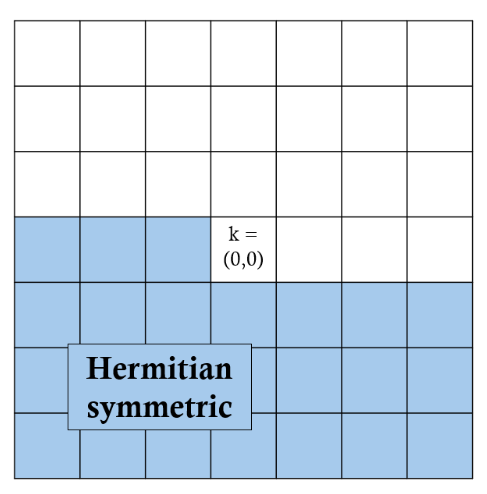

It is usual practice to use the Discrete Fourier Transform (e.g. [Sirko 2005](https://arxiv.org/abs/astro-ph/0503106):

$$ \hat\delta(\mathbf{k})=\frac{V}{N} \sum \delta(\mathbf{x})e^{-i\mathbf{k}\cdot \mathbf{x}}, \mathbf{k}\neq0$$

$$ \delta(\mathbf{x})=\frac{1}{V} \sum \hat\delta(\mathbf{k}) e^{+i\mathbf{k}\cdot \mathbf{x}}$$

where the volume term allows for boxes different that the unit box, whereas the $N$ (voxel dimension) is the normalization and depends on the Fourier conventions.

> For [`numpy`'s DFT](https://numpy.org/doc/stable/reference/routines.fft.html) this normalization is implemented for `norm='forward'`. Note that we have to include the volume normalization for ourselves.

<!-- the following:  -->
<!--
DFT:
$$A_k = \sum_{m=0}^{n-1} a_m \exp\left\{ -2\pi i \frac{mk}{n} \right\}, \quad k = 0, \dots, n-1
$$
Inverse DFT:
$$a_m = \frac{1}{n} \sum_{k=0}^{n-1} A_k \exp\left\{ 2\pi i \frac{mk}{n} \right\}, \quad m = 0, \dots, n-1$$ -->

<!-- Which is not the same normalization. There is the option to choose `norm='forward'` for numpy but here for the sake of clarity we are going to use the normalization manually.  -->

<!-- So:

$$ \hat\delta(\mathbf{k})=A_{norm} \cdot \sum \delta(\mathbf{x})e^{-i\mathbf{k}\cdot \mathbf{x}}, \mathbf{k}\neq0$$

$$ \delta(\mathbf{x})= B_{norm} \cdot \sum \hat\delta(\mathbf{k}) e^{+i\mathbf{k}\cdot \mathbf{x}}$$

with
$A_{norm} = $ -->

We need to specify a resolution. In such a field we have specific allowed Fourier modes, where the lowest allowed frequency (largest wavelength) is the one corresponding to the size of the box, whereas the highest allowed frequency (shortest wavelength) is the one correspondong to *double* the sampling distance (i.e., one wavelength should span over 3 sampling points as shown in the middle panel of the Figure below).

In 1D this is very easy to understand as we cannot represent these ($T$ indicates the period, so $k=\frac{2\pi}{T}$):

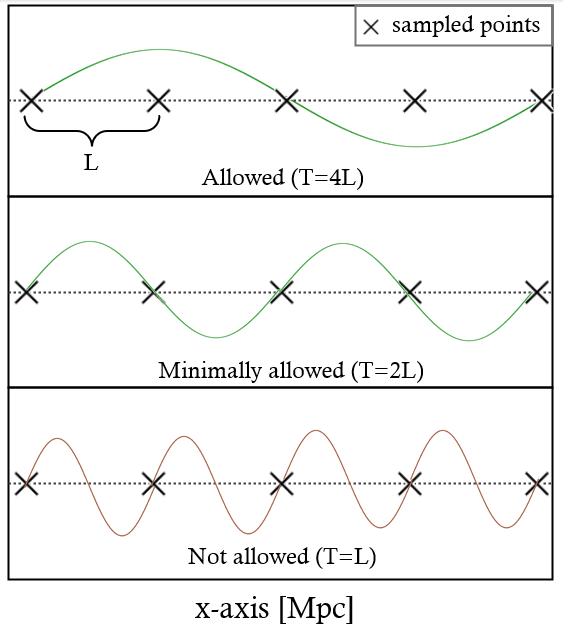

So the discrete simulation box only permits the finite set of wavenumbers:

$$
\mathbf{k} = (i, j, k), \quad \text{where} \quad ( i, j, k ) \quad\text{are integers in the range}\quad \left[-\frac{2\pi}{2\cdot L}, \frac{2\pi}{2\cdot L} \right).
$$
and $L$ is the distance between samples, i.e., $\frac{\text{box side in Mpc}}{\text{box side in voxels}}$

- **Step 1:**<br>
Choose a desired resolution (e.g., $200^3$ pixels) and volume (e.g., $300^3\; \rm Mpc^3$) and calculate the allowed Fourier spatial frequencies $k$.

In [ ]:
np.random.seed(22) # To make the results reproducible
voxel_dim      = 200
physical_dim   = 300 #Mpc

We are going to use the functionality in `numpy` (here abbreviated as `np`) to handle Fourier transforms. Lets start by calculating the allowed frequencies by `np.fft.fftfreq(voxel_dim, d=physical_dim/voxel_dim) * 2 * np.pi`

In [ ]:
allowed_frequencies = np.fft.fftfreq(voxel_dim, d=physical_dim/voxel_dim) * 2 * np.pi
print(allowed_frequencies)

[ 0.          0.02094395  0.0418879   0.06283185  0.0837758   0.10471976
  0.12566371  0.14660766  0.16755161  0.18849556  0.20943951  0.23038346
  0.25132741  0.27227136  0.29321531  0.31415927  0.33510322  0.35604717
  0.37699112  0.39793507  0.41887902  0.43982297  0.46076692  0.48171087
  0.50265482  0.52359878  0.54454273  0.56548668  0.58643063  0.60737458
  0.62831853  0.64926248  0.67020643  0.69115038  0.71209433  0.73303829
  0.75398224  0.77492619  0.79587014  0.81681409  0.83775804  0.85870199
  0.87964594  0.90058989  0.92153385  0.9424778   0.96342175  0.9843657
  1.00530965  1.0262536   1.04719755  1.0681415   1.08908545  1.1100294
  1.13097336  1.15191731  1.17286126  1.19380521  1.21474916  1.23569311
  1.25663706  1.27758101  1.29852496  1.31946891  1.34041287  1.36135682
  1.38230077  1.40324472  1.42418867  1.44513262  1.46607657  1.48702052
  1.50796447  1.52890842  1.54985238  1.57079633  1.59174028  1.61268423
  1.63362818  1.65457213  1.67551608  1.69646003  1.7

`numpy` can handle also for us the Hermitian constraints. We will use `np.fft.rfftn` (in the 'rfftn', 'r' stands for 'real', since we are Fourier transforming a real field, and 'n' indicates that the transform is n-dimensional and not 1D).

Here we create an empty array (using `np.empty()`)

In [ ]:
# We are going to use numpy's rfftn and irfftn which take into account the Hermitian constraints for us
indep_fourier_shape = np.fft.rfftn(np.empty((voxel_dim,voxel_dim,voxel_dim))).shape
print(indep_fourier_shape)

allowed_frequencies_half = abs(allowed_frequencies[:voxel_dim//2+1])
allowed_frequencies_half.shape

(200, 200, 101)


(101,)

Last dimension only considers negative k, whereas `allowed_frequencies` are mixed, we are going to use only the absolute of the first 51 elements, which is equivalent.

- **Step 2:**<br>
Create a complex-valued box  with values $\delta_k(k)=x+iy$  where $x,y\sim \mathcal{N}(0,\sqrt{P(k)\cdot V/2})$ independently. <br>

We are going to create an empty array again and fill it up with our sampled real and imaginary parts. Yoiu can use `numpy`'s `np.random.normal(mean, sigma, number of samples)` function specifying a `mean` and a `sigma` to random sample. Play with the cell below.

The first 5 samples are: [-0.09194992 -1.46335065  1.08179168 -0.23932517 -0.49112914]


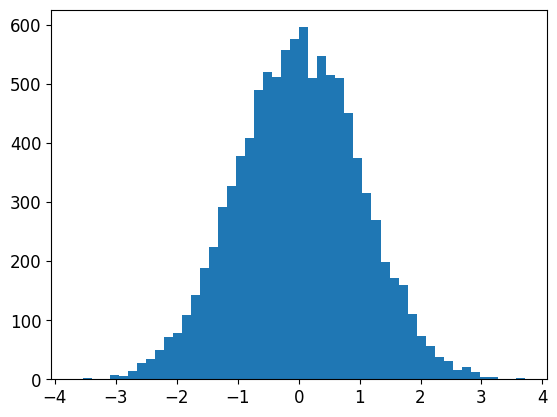

In [ ]:
# Example sampling from a normal (Gaussian) distribution
samples = np.random.normal(0, 1, 10000)
print('The first 5 samples are:', samples[:5])

# # Uncomment (Choose text and "Ctrl"+"/" on windows) if you want to plot a histogram
# plt.hist(samples, bins=50);

Now fill the code with the correct samples (1 sample inside the for-loop, no need to specify number of samples)

In [ ]:
%%time
# For-loop-friendly version
def generate_delta_k_for_loop(PS=PS):
  # create an empty arrey to fill with the samples values
  delta_k = np.empty(shape=indep_fourier_shape, dtype=complex)

  # Set the DC mode to zero
  delta_k[0,0,0] = 0+0j

  # Go over every cell, sample and fill
  for i in range(indep_fourier_shape[0]):
      for j in range(indep_fourier_shape[1]):
          for k in range(1, indep_fourier_shape[2]):
            # Specify the value of k in fourier space
            k_x = allowed_frequencies[i]
            k_y = allowed_frequencies[j]
            k_z = allowed_frequencies_half[k]
            ps = PS(np.sqrt(k_x**2+k_y**2+k_z**2)) * physical_dim**3
            # Sample and fill
            real = np.random.normal(0,np.sqrt(ps/2))
            imag = np.random.normal(0,np.sqrt(ps/2))

            delta_k[i,j,k] = real + 1j*imag
  return delta_k


delta_k = generate_delta_k_for_loop()

CPU times: user 1min 5s, sys: 85.2 ms, total: 1min 5s
Wall time: 1min 13s


You can run the for-loop version, but it's way slower. In python it is reccomended to do as much as possible using arrays ("vectorized code"). If you love for-loops so much and you want them to be fast in python you can check [numba](https://numba.pydata.org/).

In [ ]:
%%time
# Vectorized version - same exact thing but taking into advantage the fact that python is faster with vectorized calculations
def generate_delta_k(PS=PS):
  # Assume allowed_frequencies
  kx, ky, kz = allowed_frequencies, allowed_frequencies, allowed_frequencies_half

  # Make a *three* 3D grids containing the values of kx, ky and kz Fourier space coordinates respectively
  KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing='ij')
  # Make *one* 3D grid containing the values of |k|
  k_mag = np.sqrt(KX**2 + KY**2 + KZ**2)

  # Avoid DC mode
  k_mag[0, 0, 0] = 1e-15  # Just to avoid sqrt(0), value will be overwritten

  # Compute the values of the power spectrum on this grid
  ps = PS(k_mag) * physical_dim**3

  # Sample complex Gaussian field on this grid
  sigma = np.sqrt(ps / 2.0)
  real = np.random.normal(0, sigma)
  imag = np.random.normal(0, sigma)

  delta_k = real + 1j * imag

  delta_k[0, 0, 0] = 0.0  # Explicitly set DC mode to zero
  return delta_k


# Calculate it
delta_k = generate_delta_k()
print('Independent Fourier box shape:', delta_k.shape)


Independent Fourier box shape: (200, 200, 101)
CPU times: user 1.62 s, sys: 32.3 ms, total: 1.65 s
Wall time: 1.7 s


- **Step 3:**<br>
Fourier transform back to real space to get $\delta_x (x)$

In [ ]:
delta_x = np.fft.irfftn(delta_k, norm='forward') / physical_dim**3 # Scaling by the volume to satisfy the Sirko convention

Let's plot a slice of our `delta_x`. Let's use `plt.imshow(2D slice)` to plot our slice. To take a slice from our 3D array `delta_x` we just need to take `delta[:,:,0]` to take the first (index `0` in python) slice in the last axis.

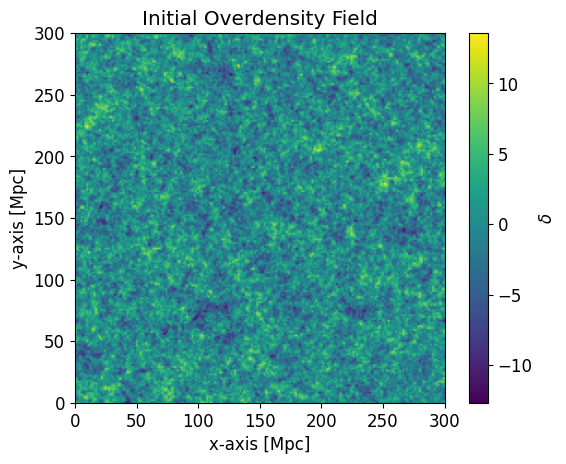

In [ ]:
# Plot it
plt.imshow(delta_x[:,:,0])


# Make it pretty-ignore
plt.imshow(delta_x[:,:,0], extent=[0,physical_dim,0,physical_dim])
plt.xlabel('x-axis [Mpc]')
plt.ylabel('y-axis [Mpc]')
plt.title('Initial Overdensity Field')
plt.colorbar(label=r'$\delta$');

Congratulations!!! 🎉 You just made your first ICs field!!!
Now, what is the realization of the PS?


> ❔ **Question**: Is the realization PS gonna be the same with the theoretical one?

<br>
<br>
<br>

### 1.3.1 Compute Realization PS

The actual PS of the field that we created is going to have some small differences compared to out theoretical PS, because of the finite sampling.

For example, in the simplest case someone wants to sample from a uniform distribution, but with only a limited number of samples, it's not going to be exactly uniform. Or if someone wants to sample from a Gaussian distribution, the variance of the samples is not going to be exactly the variance of the underlying mechanism that created them.

Here you can use out-of-the-box packages like `tuesday`, `powerbox` or create your own PS estimator. We are going to do the latter so that everything is clear (including Fourier conventions which can be confusing).

You can go through the function to understand what it's doing.

In [ ]:
def get_PS(delta_x, physical_dim, number_of_k_bins = 50):
  '''
  This returns the P(k) = sigma_k * V^-1
  '''
  voxel_dim = delta_x.shape[0]
  allowed_frequencies = np.fft.fftfreq(voxel_dim, d=physical_dim/voxel_dim) * 2 * np.pi

  # Calculate the full k-field of the realization
  delta_k_full = np.fft.fftn(delta_x, norm='forward') * physical_dim**3 # Scaling by the volume to satisfy the Sirko convention

  amps = np.abs(delta_k_full)**2

  kx, ky, kz = np.meshgrid(allowed_frequencies, allowed_frequencies, allowed_frequencies, indexing='ij')
  k = np.sqrt(kx**2 + ky**2 + kz**2)

  # Bin the power spectrum according to wave numbers
  power_spectrum_binned, k_bin_edges = np.histogram(k.flatten(), bins=number_of_k_bins, weights=amps.flatten())

  # Average power spectrum in each bin
  counts, _ = np.histogram(k.flatten(), bins=number_of_k_bins)
  power_spectrum_binned /= counts

  # Calculate bin centers
  k_bin_widths = np.diff(k_bin_edges)
  k_bin_centers = k_bin_edges[:-1] + k_bin_widths / 2

  # It's not enough to make sure the Fourier norm is correct, we need  P(k) = sigma_k * V^-1 so
  power_spectrum_binned /= physical_dim**3

  return k_bin_centers, power_spectrum_binned


# Calculate it
k, pk = get_PS(delta_x, physical_dim)

We are going to plot our realization PS that we just calculated using `plt.loglog` once again.

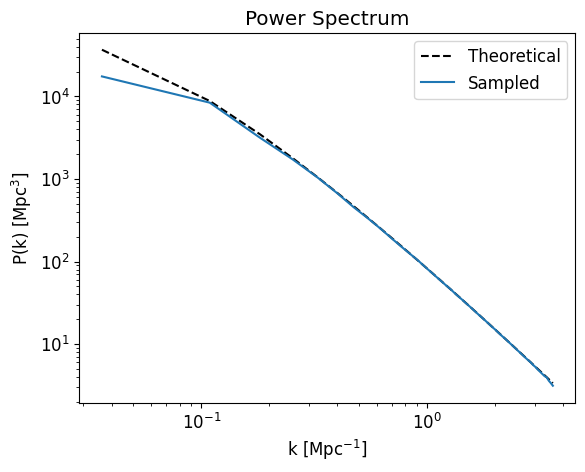

In [ ]:
# Plot it
plt.loglog(k, PS(k), color='black', linestyle='--', label='Theoretical')
plt.loglog(k, pk, label='Sampled')

# Make it pretty-ignore
plt.xlabel(r'$\rm k~[Mpc^{-1}]$')
plt.ylabel(r'$\rm P(k)~[Mpc^{3}]$')
plt.legend()
plt.title('Power Spectrum');

# # Uncomment (Choose text and "Ctrl"+"/" on windows) if you want to compare with the code `powerbox` (by Steven Murray), bin centers can be directly returned if bin_ave=True but the bins are calculated in a slightly different way
# import powerbox as pbox
# pk,k_bin_edges = pbox.get_power(delta_x, boxlength = physical_dim, a=1, b=1, ignore_zero_mode=False, bins=50, dimensionless=False, bin_ave=False)
# k_bin_widths = np.diff(k_bin_edges)
# k = k_bin_edges[:-1] + k_bin_widths / 2
# plt.loglog(k, pk, label='Sampled (Powerbox, S. Murray)', linestyle=':', linewidth=5)
# plt.legend();

<br>
<br>
<br>

## 1.4 Change seeds, amplitude and tilt and see results

Now change stuff and see how the results change as well. **Ignore the function** here and just change the parameters at the bottom of the cell and run to see the changes. We will see how things change for different parameters more clearly in PART 2 of this notebook.

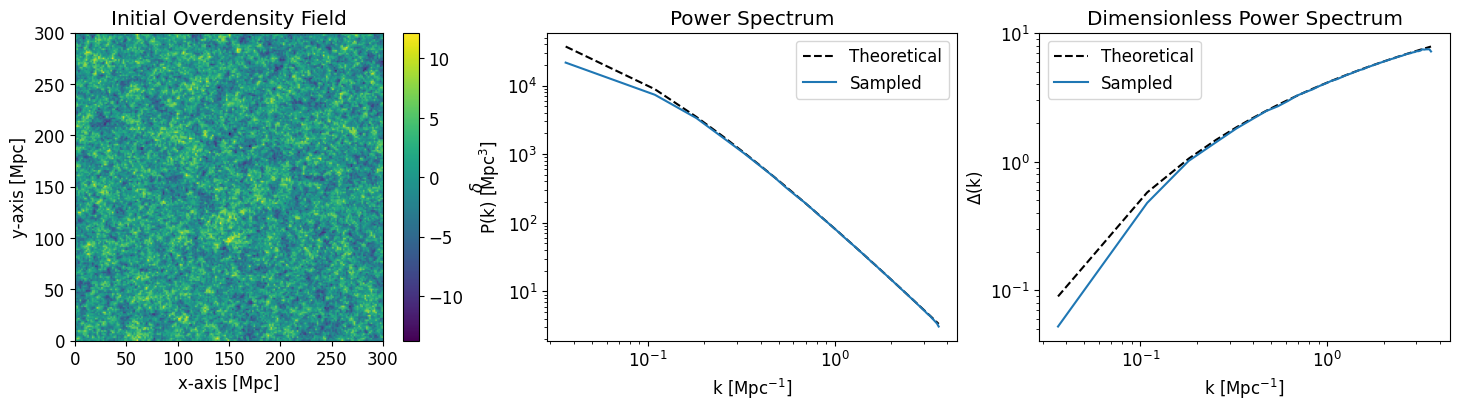

In [ ]:
def plot_field_and_ps(OMm, OMb, hlittle, PS_index, PS_amplitude, seed, voxel_dim=voxel_dim, physical_dim = physical_dim):
  np.random.seed(seed)
  # Calculate
  delta_k = generate_delta_k(PS=PS)
  delta_k[0,0,0] = 0 * np.sqrt(voxel_dim**3) +0j
  delta_x = np.fft.irfftn(delta_k, norm='forward') / physical_dim**3
  k, pk = get_PS(delta_x, physical_dim)

  # Plot it
  fig, ax = plt.subplots(1, 3, figsize=(18, 4))

  im = ax[0].imshow(delta_x[:,:,35], extent=[0,300,0,300])
  cbar = fig.colorbar(im, ax=ax[0], orientation='vertical')
  cbar.set_label(r'$\delta$')

  ax[1].loglog(k, PS(k), color='black', linestyle='--', label='Theoretical') # Explain the scaling
  ax[1].loglog(k,pk, label='Sampled')

  ax[2].loglog(k, PS(k)* k**(3)/(2*np.pi**2), color='black', linestyle='--', label='Theoretical') # Explain the scaling
  ax[2].loglog(k,pk* k**(3)/(2*np.pi**2), label='Sampled')

  # Make it pretty
  ax[0].set_xlabel('x-axis [Mpc]')
  ax[0].set_ylabel('y-axis [Mpc]')
  ax[0].set_title('Initial Overdensity Field')
  ax[1].set_xlabel(r'$\rm k~[Mpc^{-1}]$')
  ax[1].set_ylabel(r'$\rm P(k)~[Mpc^{3}]$')
  ax[1].legend()
  ax[1].set_title('Power Spectrum')
  ax[2].set_xlabel(r'$\rm k~[Mpc^{-1}]$')
  ax[2].set_ylabel(r'$\rm \Delta(k)$')
  ax[2].legend()
  ax[2].set_title('Dimensionless Power Spectrum');





# Assume some (flat) cosmology
OMm          = 0.3        # Total mass density (CDM baryons and massive neutrinos)
OMb          = 0.05       # Baryon density
hlittle      = 0.7
PS_index     = 0.965      # tilt of the power spectrum
PS_amplitude = 1.12e7        # Same qualitative effect of sigma_8
seed = 26

np.random.seed(seed)


plot_field_and_ps(OMm,OMb,hlittle,PS_index,PS_amplitude, 21)

Save a `.gif` file that shows the effect of changing seeds. **Ignore the code**, run the cell and open the file saved (press the folder icon on the left on google colab and go to `images/ICs_tutorial/movie_1.gif`).

In [ ]:
# Save a gif with changing seeds
frames_to_save = 5

newpath = 'images/ICs_tutorial/frames1/'
if not os.path.exists(newpath):
    os.makedirs(newpath)

for frame in tqdm(range(frames_to_save),'Saving frames...'):
  plot_field_and_ps(OMm, OMb, hlittle, PS_index, PS_amplitude, seed=frame)
  plt.savefig(f'images/ICs_tutorial/frames1/frame{frame}.png', bbox_inches='tight')
  plt.close()


file_list = []
for frame in range(frames_to_save):
    file_list.append(f'images/ICs_tutorial/frames1/frame{frame}.png')

output_gif = newpath+'/../'+'movie_1.gif'

# Read images
frames = [imageio.v2.imread(fname) for fname in file_list]

# Create and save GIF
fps = 5
imageio.mimsave(output_gif, frames, loop=0)  # Adjust duration as needed

Saving frames...: 100%|██████████| 5/5 [00:21<00:00,  4.29s/it]


❔ **Question**: Why is the realization PS usually below the theoretical one?
> 1st reason: We are plotting the $y$ axis in log, so distances below the theoretical one seem more severe.  <br>
> 2nd reason: We are including the $0$ mode in the PS calculation which we are explicitely setting to $0$ every time. <br>

<br>

# ✅🏁Congrats!!!🏁✅

Now you know everything you need to know about ICs! <br>
Doing everything manually was usefull pedagogically, but we don't need to reinvent the wheel every time and write code from scratch... <br>
You are experts now, so we will use the code 21cmFAST from this point onwards.

---
<br>
<br>
<br>
<br>
<br>
<br>

# PART 2: Starting with 21cmFAST

Let's create our ICs by using the functionallity in 21cmFAST.

## 2.1 Install 21cmFAST

In [ ]:
from tuesday.core import coeval2slice_x, coeval2slice_y, coeval2slice_z, plot_coeval_slice

  ## 2.1 Create ICs and plot
  (slice, velocity field, PDF, PS)

In [ ]:
### Create and visualize the initial conditions (standardize this)

# set up the parameters
input_dict={
    'BOX_LEN'   : 300,
    'DIM'       : 200,
    'HII_DIM'   : 200,
    'N_THREADS' : 1  ,

    "SIGMA_8": 0.82,
    "hlittle": 0.7,
    "OMm": 0.3,
    "OMb": 0.05,
    "POWER_INDEX": 0.9665}
inputs = p21c.InputParameters.from_template("simple", random_seed=123).evolve_input_structs(**input_dict) #adapt N_THREADS to your machine

# make initial conditions
initial_conditions = p21c.compute_initial_conditions(inputs=inputs, cache=cache,  regenerate=False)
delta_x = initial_conditions.lowres_density.value[:,:,:] * units.dimensionless_unscaled

# Run this if you want to see everythig in the `initial_conditions` class
print('These are the contents of the initial_conditions:', initial_conditions.__dict__.keys())

/usr/local/lib/python3.12/dist-packages/attr/_make.py:3279: UserWarning: Resolution is likely too low for accurate evolved density fields
 It Is recommendedthat you either increase the resolution (DIM/BOX_LEN) orset the EVOLVE_DENSITY_LINEARLY flag to 1
  v(inst, attr, value)


These are the contents of the initial_conditions: dict_keys(['inputs', 'dummy', 'initial', 'lowres_density', 'lowres_vx', 'lowres_vy', 'lowres_vz', 'hires_density', 'hires_vx', 'hires_vy', 'hires_vz', 'lowres_vx_2LPT', 'lowres_vy_2LPT', 'lowres_vz_2LPT', 'hires_vx_2LPT', 'hires_vy_2LPT', 'hires_vz_2LPT', 'lowres_vcb', 'struct', 'cstruct'])


Now let's use `tools.plot_coeval_slice` from `tuesday` to plot a slice.

<Axes: xlabel='Distance [$\\mathrm{Mpc}$]', ylabel='Distance [$\\mathrm{Mpc}$]'>

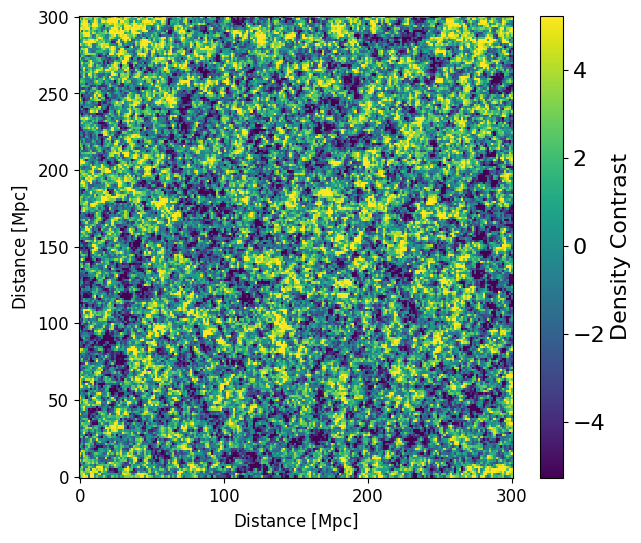

In [ ]:
# Let's plot a slice!!
tools.plot_coeval_slice(delta_x, input_dict['BOX_LEN']*units.Mpc, fontsize=12)

<Axes: xlabel='Density Contrast', ylabel='Counts'>

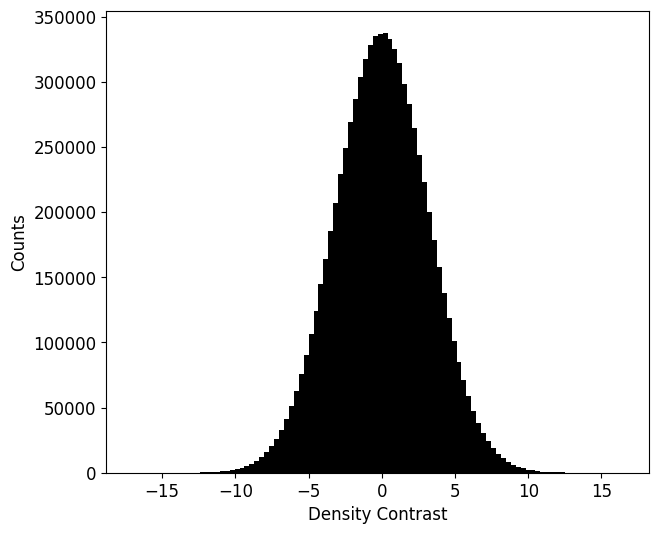

In [ ]:
# Plot the PDF of the ICs
tools.plot_pdf(delta_x.flatten(), hist_kwargs={'bins':100, 'color':'black'}, fontsize=12)

/usr/local/lib/python3.12/dist-packages/powerbox/tools.py:287: RuntimeWarning: invalid value encountered in divide
  np.bincount(
/usr/local/lib/python3.12/dist-packages/powerbox/tools.py:551: RuntimeWarning: invalid value encountered in divide
  np.bincount(


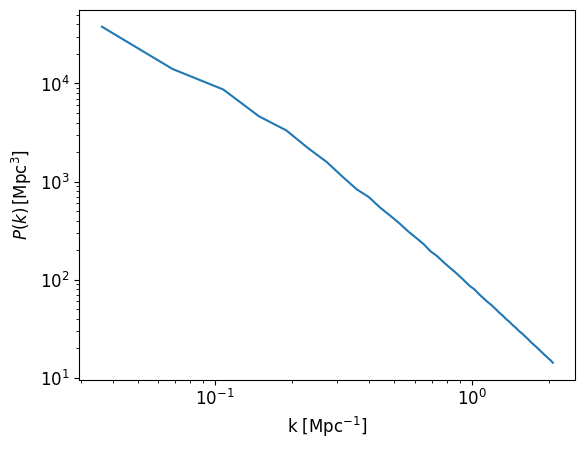

In [ ]:
# Calculate the PS with tuesday
ps1, ps2 = tools.calculate_ps_coeval(delta_x,
                                     input_dict['BOX_LEN']*units.Mpc,
                                     log_bins=False,
                                     k_bins=50,
                                     deltasq=False)
# Create figure
fig, ax = plt.subplots()
# Plot 1D PS
tools.plot_1d_power_spectrum_k(ps1, ax=ax, log=[True, True], fontsize=12)

# # Uncomment (Choose text and "Ctrl"+"/" on windows) if you want to compare with the previous PS
# k, pk = get_PS(delta_x, physical_dim, number_of_k_bins = 50)
# plt.loglog(k, pk, label='DIY', color='tab:orange')

plt.show()

 ## 2.2 Change the cosmology, and plot the difference wrt the fiducial

(slice, PDF, PS and ratio, Cross-Correlation Coefficient (CCC))



In [ ]:
# set up the parameters to your preference
new_input_dict={
    'BOX_LEN'   : 300,
    'DIM'       : 200,
    'HII_DIM'   : 200,
    'N_THREADS' : 1  ,

    "SIGMA_8": 0.6,
    "hlittle": 0.7,
    "OMm": 0.5,
    "OMb": 0.05,
    "POWER_INDEX": 0.9665}

new_inputs = p21c.InputParameters.from_template("simple", random_seed=123).evolve_input_structs(**new_input_dict) #adapt N_THREADS to your machine

# make initial conditions
new_initial_conditions = p21c.compute_initial_conditions(inputs=new_inputs, cache=cache,  regenerate=True)
new_delta_x = new_initial_conditions.lowres_density.value[:,:,:] * units.dimensionless_unscaled

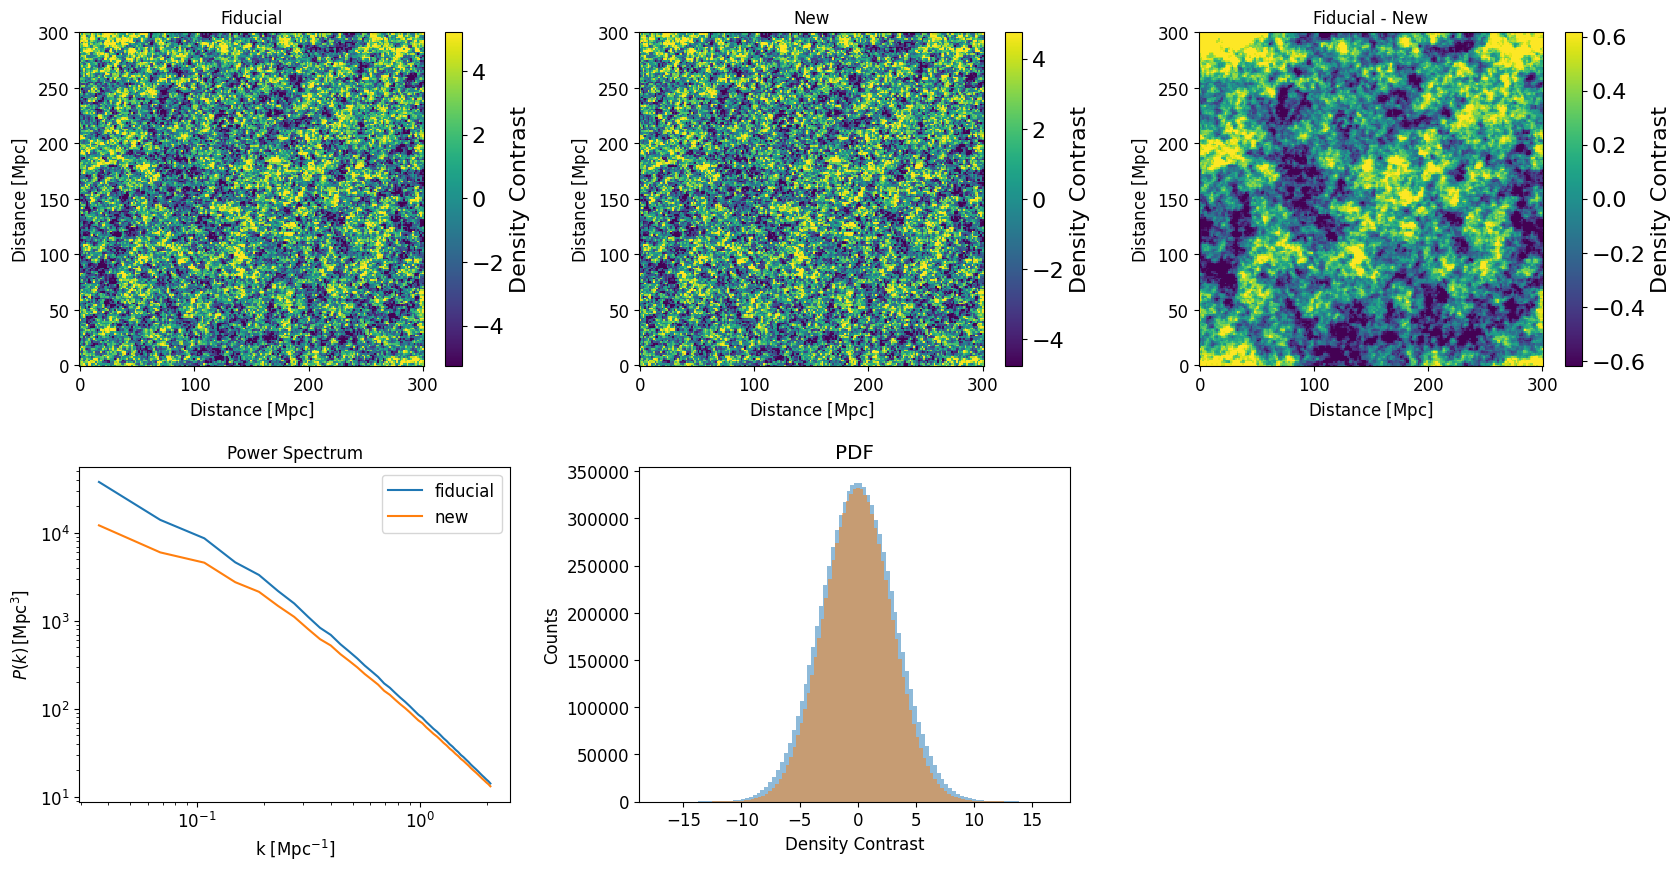

In [ ]:
# Create figure
fig, ax = plt.subplots(2,3, figsize=(20,10), gridspec_kw={'hspace': 0.3, 'wspace':0.3})
# Plot density contrasts
tools.plot_coeval_slice(delta_x, 300*units.Mpc, fontsize=12, ax=ax[0,0], title = 'Fiducial')
ax[0,0].set_title(label= 'Fiducial', fontsize=12)
tools.plot_coeval_slice(new_delta_x, 300*units.Mpc, fontsize=12, ax=ax[0,1], title = 'New')
ax[0,1].set_title(label= 'New', fontsize=12)
tools.plot_coeval_slice(delta_x - new_delta_x, 300*units.Mpc, fontsize=12, ax=ax[0,2], title = 'Fiducial - New')
ax[0,2].set_title(label= 'Fiducial - New', fontsize=12)

# Plot PS
tools.plot_1d_power_spectrum_k(ps1, ax=ax[1,0], log=[True, True], legend='fiducial', legend_kwargs={}, title = 'Power Spectrum', fontsize=12)
new_ps1, new_ps2 = tools.calculate_ps_coeval(new_delta_x, new_input_dict['BOX_LEN']*units.Mpc, log_bins=False, k_bins=50, deltasq=False, calc_2d=False)
tools.plot_1d_power_spectrum_k(new_ps1, ax=ax[1,0], log=[True, True], color='tab:orange', legend='new', legend_kwargs={}, fontsize=12)

# Plots PDFs
tools.plot_pdf(delta_x.flatten(), hist_kwargs={'bins':100, 'color':'tab:blue', 'alpha':0.5}, ax=ax[1,1], title = 'PDF', fontsize=12)
tools.plot_pdf(new_delta_x.flatten(), hist_kwargs={'bins':100, 'color':'tab:orange', 'alpha':0.5}, ax=ax[1,1], fontsize=12)

# Plot CCC
ax[1,2].remove()

The CCC between 2 fields A and B is defined as (also commonly referred to as the cross-power spectrum):

$$ \mathrm{CCC}(k) = \frac{ P_{AB}(k)}{ \sqrt{P_{AA}(k)\, P_{BB}(k)} } $$

Text(0, 0.5, '$\\rm CCC(k)$')

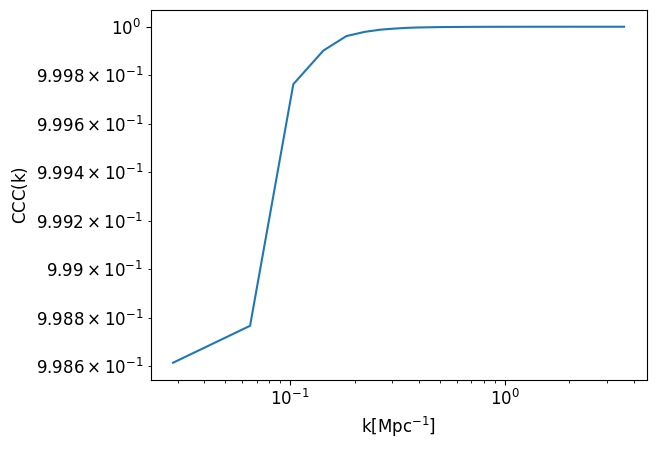

In [ ]:
import powerbox as pbox

pkAB, k  = pbox.get_power(deltax = delta_x, boxlength = new_input_dict['BOX_LEN'], deltax2=new_delta_x)
pkA,  k  = pbox.get_power(deltax = delta_x, boxlength = new_input_dict['BOX_LEN'], deltax2=None)
pkB,  k  = pbox.get_power(deltax = new_delta_x, boxlength = new_input_dict['BOX_LEN'], deltax2=None)
CCC = pkAB/(np.sqrt(pkA*pkB))

# Plot it
plt.loglog(k,CCC)

# Make it pretty
plt.xlabel(r'$\rm k [Mpc^{-1}]$')
plt.ylabel(r'$\rm CCC(k)$')

> ❔ **Question**: What does the CCC say about the two fields it compares?

<br>

# ✅🏁The end🏁✅

Footnotes:

$^1$ ICs are a GRF within some errors. There are works that study the subtle non-Gaussianities on the ICs, which encode information about the inflationary epoch before recombination. See Appendix A.4 for an implementation of non-Gaussianities.

$^2$ the term stationary is often used, for example in [this review](https://www.math.ntnu.no/emner/TMA4250/2016v/abrahamsen2.pdf), homogenous is reffered to as wide-sense stationary and isotropy as wide-sense isotropy, see also this [paper](https://inspirehep.net/files/e2a30eac8f95a3f50deb84e09198b7bc) or [this](https://inria.hal.science/hal-01414707v2/document).

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Appendix

We need a `delta_k` for this appendix, generate it:

In [ ]:
delta_k = generate_delta_k()

### A.1 Sanity check that the mean of a field in real space is defined by the DC mode.

In [ ]:
# Sanity check
# Set the DC mode (note: it controls the mean but the exact way depends on the choice of Fourier conventions)
# Try to change it and see the results
field_mean = 0
delta_k[0,0,0] = field_mean *physical_dim**3 +0j
delta_x = np.fft.irfftn(delta_k, norm='forward') / physical_dim**3 # Scaling by the volume to satisfy the Sirko convention

# Check the mean
print('The mean defined by the DC mode is:', np.linalg.norm(delta_k[0,0,0]) /  physical_dim**3, '\nThe mean of the field in real space is:', np.mean(delta_x))

The mean defined by the DC mode is: 0.0 
The mean of the field in real space is: 4.0323300254385683e-19



### A.2 Realization PS Nyquist Frequency

The highest frequency that we are sampling is obviously our cutoff for the represented frequencies. We should not have any frequencies above that right?

$k_{Nyquist}=\frac{\pi}{VoxelLengh}$

In [ ]:
k_nyquist = np.pi * voxel_dim / physical_dim
print(f"Nyquist frequency: k_nyquist = {k_nyquist:.3f} Mpc^-1")

print('And this frequency should be the highest out of the allowed ones:\n\n', abs(allowed_frequencies_half) )

Nyquist frequency: k_nyquist = 2.094 Mpc^-1
And this frequency should be the highest out of the allowed ones:

 [0.         0.02094395 0.0418879  0.06283185 0.0837758  0.10471976
 0.12566371 0.14660766 0.16755161 0.18849556 0.20943951 0.23038346
 0.25132741 0.27227136 0.29321531 0.31415927 0.33510322 0.35604717
 0.37699112 0.39793507 0.41887902 0.43982297 0.46076692 0.48171087
 0.50265482 0.52359878 0.54454273 0.56548668 0.58643063 0.60737458
 0.62831853 0.64926248 0.67020643 0.69115038 0.71209433 0.73303829
 0.75398224 0.77492619 0.79587014 0.81681409 0.83775804 0.85870199
 0.87964594 0.90058989 0.92153385 0.9424778  0.96342175 0.9843657
 1.00530965 1.0262536  1.04719755 1.0681415  1.08908545 1.1100294
 1.13097336 1.15191731 1.17286126 1.19380521 1.21474916 1.23569311
 1.25663706 1.27758101 1.29852496 1.31946891 1.34041287 1.36135682
 1.38230077 1.40324472 1.42418867 1.44513262 1.46607657 1.48702052
 1.50796447 1.52890842 1.54985238 1.57079633 1.59174028 1.61268423
 1.63362818 1.65457

So we should not worry about it right? Wrong!!
This is the cutoff frequency in one dimension, we are working in 3D.
Let's plot it together with our PS.

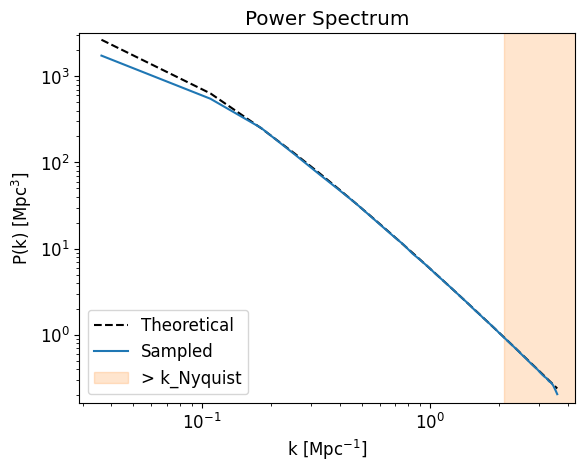

In [ ]:
# Calculate it
k, pk = get_PS(delta_x, physical_dim)
# Plot it
plt.loglog(k, PS(k), color='black', linestyle='--', label='Theoretical') # Explain the scaling
plt.loglog(k, pk, label='Sampled')
plt.fill_between(np.linspace(k_nyquist,k[-1]+10), 0, 1e5, color='tab:orange', alpha=0.2, label='> k_Nyquist')
# plt.axvline(k_nyquist, color='red', label='k_Nyquist', linestyle='--')
# Make it pretty
plt.ylim([np.min([pk,PS(k)])*0.8, np.max([pk, PS(k)])*1.2])
plt.xlim([np.min(k)*0.8, np.max(k)*1.2])
plt.xlabel(r'$\rm k~[Mpc^{-1}]$')
plt.ylabel(r'$\rm P(k)~[Mpc^{3}]$')
plt.legend()
plt.title('Power Spectrum');

You can see that the PS has values on some k bins that are above the $k_{Nyquist}$. For caclulating PS we are taking averages on spherical shells around $k=0$ on our Fourier space **box**. Since it's a box we have values above $k_{Nyquist}$ that extend up until the corners of this box. Although possible to compute, they should not be trusted as we are averaging less data.

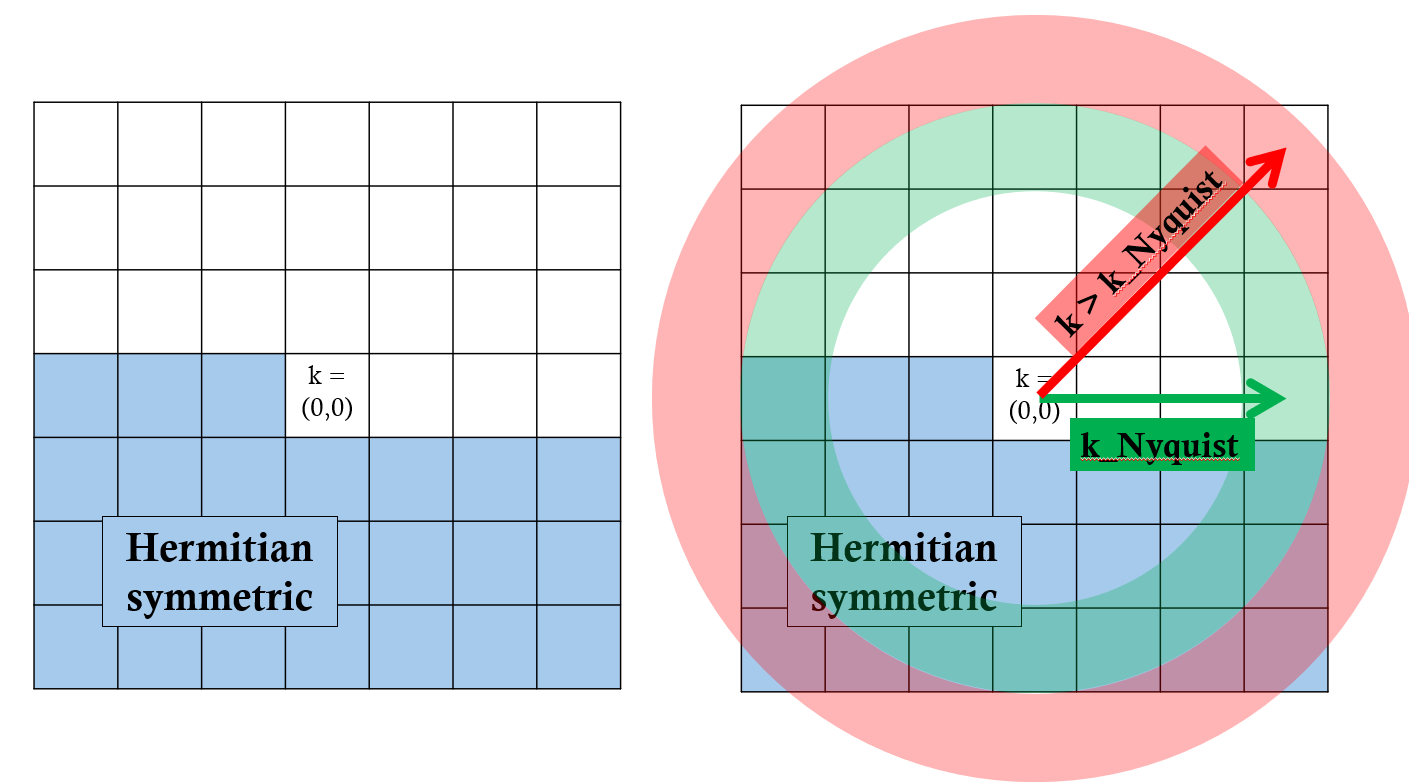

### A.3 Why is the PS realization usually below the theoretical one?

> 1st reason: We are plotting the $y$ axis in log, so distances below the theoretical one seem more severe.  <br>
> 2nd reason: We are including the $0$ mode in the PS calculation which we are explicitely setting to $0$ every time. <br>
> 3rd reason: the realization PS follows a **Gamma distribution**.

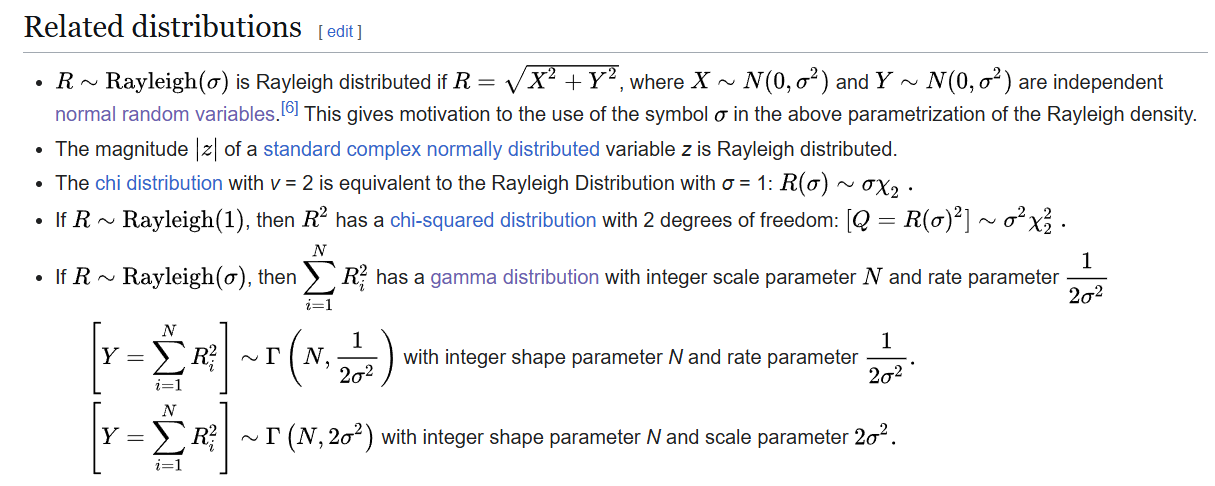

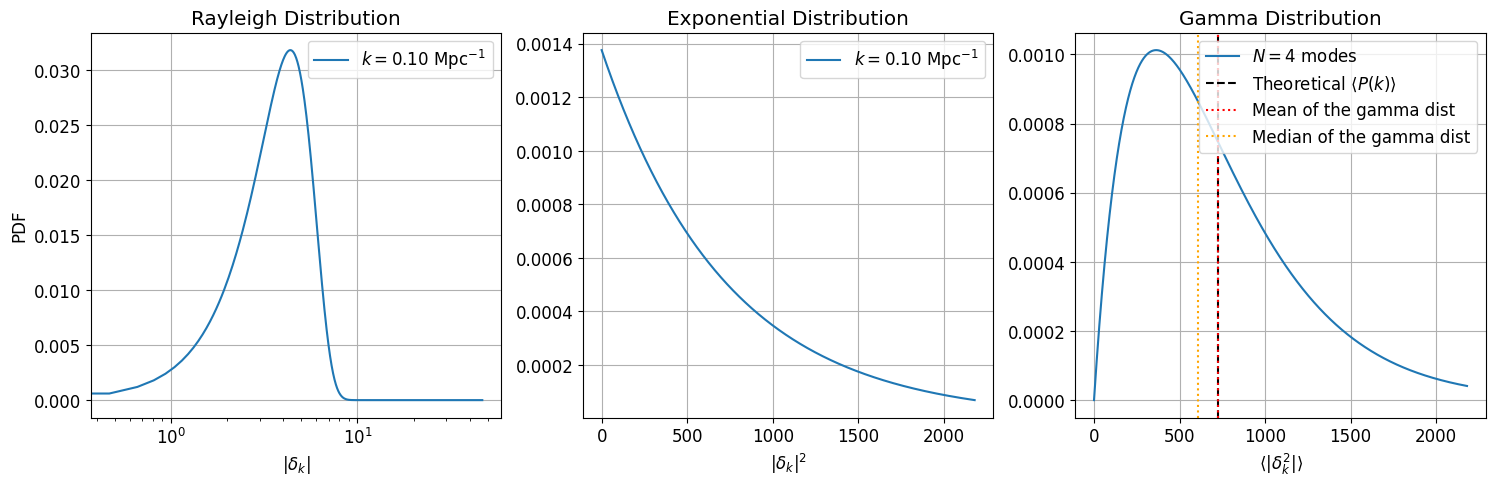

Fraction of samples below the Gamma mean: 0.594


In [ ]:
from scipy.stats import rayleigh, expon, gamma
# Your box size and theoretical PS
L = 300           # Mpc (box length)
V = L**3          # Volume
k0 = 0.1          # Chosen wavenumber in 1/Mpc
P_k0 = PS(k0)     # Theoretical power spectrum at k0

n_modes = 4  # Number of modes in the bin, you can vary this to see the effect of the gamma distribution

sigma = np.sqrt(P_k0 / 2)
powers = np.linspace(0, 3 * P_k0, 10000)

# Rayleigh
pdf_rayleigh = rayleigh(scale=sigma).pdf(powers)
# Exponential
pdf_expon = expon(scale=P_k0).pdf(powers)
# Gamma
shape = n_modes / 2 # Gamma distribution parameter
scale = 2 * P_k0 / n_modes  # so that mean = shape * scale = P_k
gamma_dist = gamma(a=shape, scale=scale)
pdf_gamma = gamma_dist.pdf(powers)
mean = gamma_dist.mean()
fraction_below_mean = gamma_dist.cdf(mean)



fig, ax = plt.subplots(1,3, figsize=(18,5))

# Plot
ax[0].plot(np.sqrt(powers), pdf_rayleigh, label=fr'$k={k0:.2f}~\mathrm{{Mpc}}^{{-1}}$')
ax[0].set_xlabel(r'$|\delta_k|$')
ax[0].set_ylabel('PDF')
ax[0].set_title('Rayleigh Distribution')
ax[0].set_xscale('log')

ax[1].plot(powers, pdf_expon, label=fr'$k={k0:.2f}~\mathrm{{Mpc}}^{{-1}}$')
ax[1].set_xlabel(r'$|\delta_k|^2$')
ax[1].set_title('Exponential Distribution')

ax[2].plot(powers, pdf_gamma, label=fr'$N={n_modes}$ modes')
ax[2].axvline(P_k0, color='k', linestyle='--', label='Theoretical $\\langle P(k) \\rangle$')
ax[2].axvline(gamma.mean(a=shape, scale=scale), color='red', linestyle=':', label='Mean of the gamma dist')
ax[2].axvline(gamma.median(a=shape, scale=scale), color='orange', linestyle=':', label='Median of the gamma dist')
ax[2].set_xlabel(r'$\langle|\delta_k^2|\rangle$')
ax[2].set_title('Gamma Distribution')

ax[0].grid()
ax[0].legend()
ax[1].grid()
ax[1].legend()
ax[2].legend()
ax[2].grid()

plt.show()

print(f"Fraction of samples below the Gamma mean: {fraction_below_mean:.3f}")

## A.4 Non-Gaussianities

The real ICs field could have deviations from it's previously assumed gaussian nature. Here we model the simplest form of non-gaussianity reffered to as "local".


We only consider models that have a primordial bispectrum, defined as:

$$
\langle \Phi(\mathbf{k}_1) \Phi(\mathbf{k}_2) \Phi(\mathbf{k}_3) \rangle = (2\pi)^3 \delta^{(3)}(\mathbf{k}_1 + \mathbf{k}_2 + \mathbf{k}_3) B_\Phi(k_1, k_2, k_3),
$$

where $\Phi(\mathbf{k})$ is the primordial potential.

<!-- The local shape can be characterized by the bispectrum:

$$
B_{\Phi}^{\text{local}}(k_1, k_2, k_3) = 2 f_{\text{NL}}^{\text{local}} \left[ P_{\Phi}(k_1) P_{\Phi}(k_2) + P_{\Phi}(k_2) P_{\Phi}(k_3) + P_{\Phi}(k_3) P_{\Phi}(k_1) \right]
$$ -->

The relation between the primordial potential $\Phi(\mathbf{k})$ and the matter overdensity $\delta(\mathbf{k}, z)$ in Fourier space is:

$$
\delta(\mathbf{k}, z) = \mathcal{\alpha}(k, z) \cdot \Phi(\mathbf{k})
$$

where $\mathcal{\alpha}(k, z)$ is given by:(https://arxiv.org/pdf/0805.3580 also look at https://arxiv.org/pdf/2009.01245)

$$
\mathcal{\alpha}(k, z) = \frac{2}{3} \frac{k^2 c^2 T(k) D(z)}{H_0^2 \Omega_m}
$$



Here we consider the simplest so called "local" type of non-Gaussianity, for which, the potential $\Phi$ can be generated as:

$$
\Phi(\mathbf{x}) = \Phi_G(\mathbf{x}) + f_{\rm NL} \left( \Phi_G^2(\mathbf{x}) - \langle \Phi_G^2 \rangle \right)
$$

where $ f_{\text{NL}}^{\text{local}}$ is the non-Gaussianity parameter and $ P_{\Phi}(k) $ is the power spectrum of the primordial potential.

$f_{NL}^{local}$ is connected with the bispectrum through:

$$ B_{\Phi}^{\text{local}}(k_1, k_2, k_3)
= 2 f_{\mathrm{NL}}^{\text{local}}
\left[
P_{\Phi}(k_1) P_{\Phi}(k_2)
+ P_{\Phi}(k_2) P_{\Phi}(k_3)
+ P_{\Phi}(k_3) P_{\Phi}(k_1)
\right]$$

Where $k_1, k_2, k_3$ vectors with $k_3\ll k1\simeq k_2$:

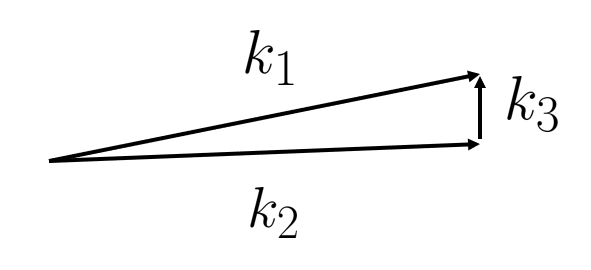

In [ ]:
from astropy.cosmology.realizations import Planck18 as cosmo
from astropy.constants import c
from astropy import units as u
# Convert H0 (km / s / Mpc) into 1 / Mpc using the speed of light
H0 = cosmo.H0            # 67.66 km / (s Mpc)
H0_si = H0.to(u.Hz)      # Convert to Hz (1 / s)
H0_Mpcinv = (H0_si / c).to(1 / u.Mpc)
print(H0_Mpcinv)

0.00022568946681106964 1 / Mpc


In [ ]:
def alpha(k, T=Transfer_function,  Dz = 1, H0=0.00022568946681106964, OMm=0.3): # H0 in km Mpc^-1, s^-1
   return 2/3 * ((k**2 * T(k)*Dz)/ (H0**2*OMm))


def apply_NG(delta_x, physical_dim, alpha, f_NL):
  voxel_dim = delta_x.shape[0]
  delta_k = np.fft.rfftn(delta_x, norm='forward')* physical_dim**3

  # Get phi_k from delta_k-------------------------------------------------------------------
  allowed_frequencies = np.fft.fftfreq(voxel_dim, d=physical_dim/voxel_dim) * 2 * np.pi
  allowed_frequencies_r = np.fft.rfftfreq(voxel_dim, d=physical_dim/voxel_dim) * 2 * np.pi

  kx, ky, kz = allowed_frequencies, allowed_frequencies, allowed_frequencies_r
  # Make a *three* 3D grids containing the values of kx, ky and kz Fourier space coordinates respectively
  KX, KY, KZ = np.meshgrid(kx, ky, kz, indexing='ij')
  # Make *one* 3D grid containing the values of |k|
  k_mag = np.sqrt(KX**2 + KY**2 + KZ**2)

  # Avoid DC mode
  k_mag[0, 0, 0] = 1e-10  # Just to avoid sqrt(0), value will be overwritten

  phi_k = delta_k/alpha(k_mag)

  phi_k[0, 0, 0] = 0.0  # Remove DC mode

  # Get phi_x from phi_k-------------------------------------------------------------------
  phi_x = np.fft.irfftn(phi_k, norm='forward') / physical_dim**3

  # Get phi_x_ng from phi_x-------------------------------------------------------------------
  phi_x_ng = phi_x + f_NL * (phi_x**2 - np.mean(phi_x**2))

  # Get phi_k_ng from phi_x_ng-------------------------------------------------------------------
  phi_k_ng = np.fft.rfftn(phi_x_ng, norm='forward') * physical_dim**3

  # Get delta_k_ng from phi_k_ng
  delta_k_ng = alpha(k_mag) * phi_k_ng

  # Get delta_x_ng from delta_k_ng
  delta_x_ng = np.fft.irfftn(delta_k_ng, norm='forward') / physical_dim**3

  return delta_x_ng

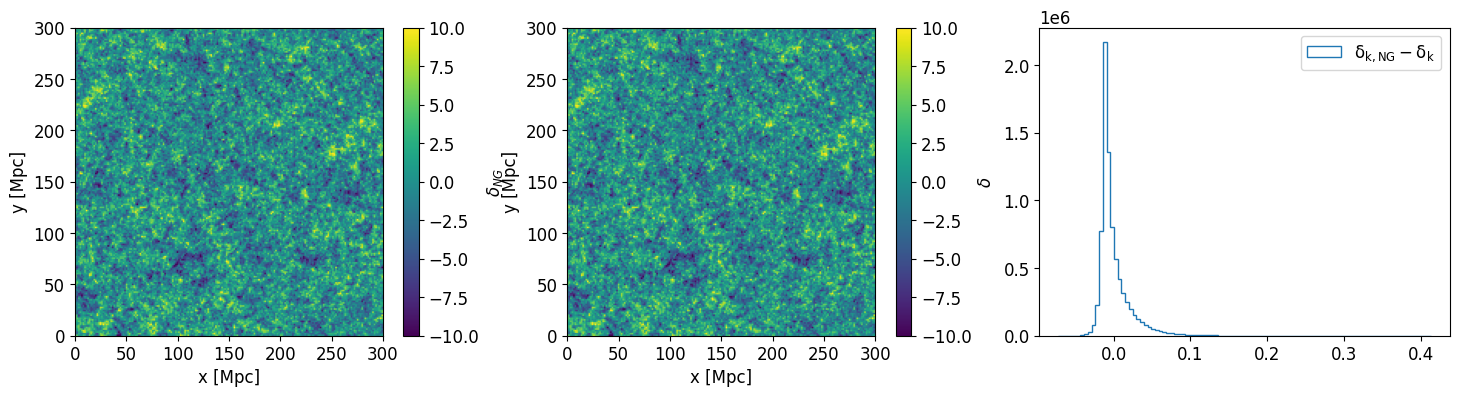

In [ ]:
f_NL = 100

fig, ax = plt.subplots(1,3,figsize=(18,4))
delta_x_ng = apply_NG(delta_x, physical_dim=300, alpha=alpha, f_NL=f_NL)
im0 = ax[0].imshow(delta_x_ng[:,:,0], extent=[0,300,0,300], vmin=-10, vmax=10)
im1 = ax[1].imshow(delta_x[:,:,0], extent=[0,300,0,300], vmin=-10, vmax=10)
im2 = ax[2].hist((delta_x_ng - delta_x).flatten(), bins=100, histtype='step', label=r'$\rm \delta_{k,NG} - \delta_{k}$')

cbar0 = fig.colorbar(im0, ax=ax[0], orientation='vertical')
cbar0.set_label(r'$\delta_{NG}$')

cbar1 = fig.colorbar(im1, ax=ax[1], orientation='vertical')
cbar1.set_label(r'$\delta$')
ax[0].set_xlabel('x [Mpc]')
ax[0].set_ylabel('y [Mpc]')
ax[1].set_xlabel('x [Mpc]')
ax[1].set_ylabel('y [Mpc]')

plt.legend()
plt.show()